In [1]:
# Imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
# Read dataset
# dataset = pd.read_csv('Google_Stock_Price_Train.csv',index_col="Date",parse_dates=True)
file = r'dados_fase4.xls'
df = pd.read_excel(file)

training_set = df[['rank_total_ronda5','rank_total_ronda10','rank_total_ronda15','rank_total_ronda20']]
result_data = np.array(df[['rank_total_final']])
print(training_set)

y_vals = np.zeros(len(result_data))
for i in range(len(result_data)):
    if result_data[i] >= np.percentile(result_data, 5):
        y_vals[i] = 0
    if result_data[i] >= np.percentile(result_data, 10):
        y_vals[i] = 1
    if result_data[i] >= np.percentile(result_data, 25):
        y_vals[i] = 2
    if result_data[i] >= np.percentile(result_data, 50):
        y_vals[i] = 3
    if result_data[i] >= np.percentile(result_data, 75):
        y_vals[i] = 4
y_vals = y_vals / 4

# Create training mask
train_mask = np.full(len(result_data), False)
train_mask[:700] = True
np.random.shuffle(train_mask)

y_train = y_vals[train_mask]
y_val = y_vals[~train_mask]

KeyError: "['rank_total_final'] not in index"

In [ ]:
#Data cleaning
training_set.isna().any()

# Feature Scaling Normalization
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)
# assert len(training_set_scaled) == len(y_train)

# Creating a data structure with 4 timesteps and 1 output
X_vals = []
for i in range(len(training_set_scaled)):
    X_vals.append(training_set_scaled[i])
X_vals = np.array(X_vals)
X_train = X_vals[train_mask]
X_val = X_vals[~train_mask]

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
print(X_train)

In [4]:
# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.python.framework import ops

In [5]:
# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
700/700 [==============================] - 2s 2ms/sample - loss: 0.2798
Epoch 2/100
700/700 [==============================] - 0s 612us/sample - loss: 0.0935
Epoch 3/100
700/700 [==============================] - 0s 491us/sample - loss: 0.0764
Epoch 4/100
700/700 [==============================] - 0s 476us/sample - loss: 0.0713
Epoch 5/100
700/700 [==============================] - 0s 483us/sample - loss: 0.0700
Epoch 6/100
700/700 [==============================] - 0s 481us/sample - loss: 0.0672
Epoch 7/100
700/700 [==============================] - 0s 476us/sample - loss: 0.0695
Epoch 8/100
700/700 [==============================] - 0s 485us/sample - loss: 0.0672
Epoch 9/100
700/700 [==============================] - 0s 468us/sample - loss: 0.0680
Epoch 10/100
700/700 [==============================] - 0s 487us/sample - loss: 0.0676
Epoch 11/100
700/700 [==============================] - 0s 472us/sample - loss: 0.0695
Epoch 12/100
700/700 [==============================] 

In [6]:
# Getting the final positions in the last stage
predicted_position = regressor.predict(X_val)
predicted_position = np.round(predicted_position*4).astype(int)
predicted_position = predicted_position[:,-1]
y_val = y_val * 4
y_val = y_val.astype(int)

Confusion matrix, without normalization
[[ 3 17  1  0  1]
 [ 0  9  3  2  0]
 [ 0 10 25  7  0]
 [ 0  1 13 32  1]
 [ 0  0  0 12 30]]
Normalized confusion matrix
[[0.14 0.77 0.05 0.   0.05]
 [0.   0.64 0.21 0.14 0.  ]
 [0.   0.24 0.6  0.17 0.  ]
 [0.   0.02 0.28 0.68 0.02]
 [0.   0.   0.   0.29 0.71]]


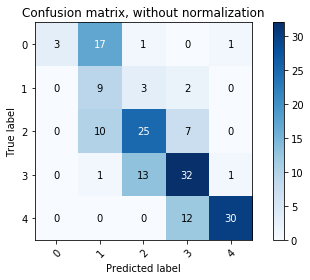

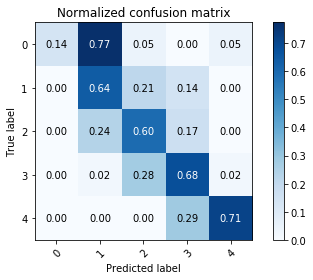

In [23]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, predicted_position, classes=['top_5', 'top_10', 'top_25', 'top_50', 'top_75'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, predicted_position, classes=['top_5', 'top_10', 'top_25', 'top_50', 'top_75'], 
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()